<a href="https://colab.research.google.com/github/GdGato/Fast_IA/blob/339/Introducci%C3%B3n_a_Visi%C3%B3n_por_Computadora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a Visión por Computadora

In [2]:
from fastai.vision.all import *

Este tutorial se centra en cómo construir rápidamente un 'Learner' y ajustar finamente un modelo preentrenado en la mayoría de las tareas de visión por computadora.

## Clasificación de una sola etiqueta

Para esta tarea, utilizaremos el conjunto de datos [Oxford-IIIT Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), que contiene imágenes de gatos y perros de 37 razas diferentes. Primero mostraremos cómo construir un clasificador simple de gatos contra perros y luego un modelo un poco más avanzado que puede clasificar todas las razas.

El conjunto de datos se puede descargar y descomprimir con la siguiente línea de código:

In [3]:
path = untar_data(URLs.PETS)

Solo realizará esta descarga una vez y devolverá la ubicación del archivo descomprimido. Podemos verificar qué hay dentro con el método **.ls()**.

In [3]:
path.ls()

(#3) [Path('/root/.fastai/data/oxford-iiit-pet/models'),Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

Ignoraremos la carpeta de anotaciones por ahora y nos centraremos en la de imágenes. '[get_image_files](https://docs.fast.ai/data.transforms.html#get_image_files)' es una función de fastai que nos ayuda a obtener todos los archivos de imagen (de forma recursiva) en una carpeta.

In [4]:
files = get_image_files(path/"images")
len(files)

7390

## Diferenciación entre Gatos y Perros en la Etiquetación de Datos

Para etiquetar nuestros datos en el problema de clasificación entre gatos y perros, es necesario identificar qué nombres de archivo corresponden a imágenes de perros y cuáles a imágenes de gatos. Existe una manera sencilla de distinguirlos: el nombre del archivo comienza con una letra mayúscula para gatos y con una letra minúscula para perros.


In [5]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_27.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_174.jpg'))

Podemos definir una función de etiquetado sencilla de la siguiente manera:





In [16]:
def label_func(f): return f[0].isupper()

In [14]:
def get_y(o): return o[0].isupper()


Para preparar nuestros datos para un modelo, es necesario colocarlos en un objeto [DataLoaders](https://docs.fast.ai/data.core.html#dataloaders). En este caso, contamos con una función que etiqueta utilizando los nombres de archivo, por lo que utilizaremos [ImageDataLoaders.from_name_func](https://docs.fast.ai/vision.data.html#imagedataloaders.from_name_func). Existen otros métodos de fábrica en [ImageDataLoaders](https://docs.fast.ai/vision.data.html#imagedataloaders) que podrían ser más adecuados para su problema, así que asegúrese de revisarlos todos en `vision.data`.


In [7]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Hemos pasado a esta función el directorio en el que estamos trabajando, los archivos que hemos obtenido, nuestra `label_func` y una última pieza llamada `item_tfms`. Esta última es una transformación aplicada a todos los elementos de nuestro conjunto de datos que redimensionará cada imagen a 224 por 224. Esto se logra mediante un recorte aleatorio en la dimensión más grande para hacerlo cuadrado, seguido de un redimensionamiento a 224 por 224. Si no proporcionamos esto, obtendríamos un error más adelante, ya que sería imposible agrupar los elementos en lotes.

Luego, podemos verificar si todo parece estar bien con el método [show_batch](https://docs.fast.ai/vision.gan.html#show_batch) (True corresponde a gato, False a perro):


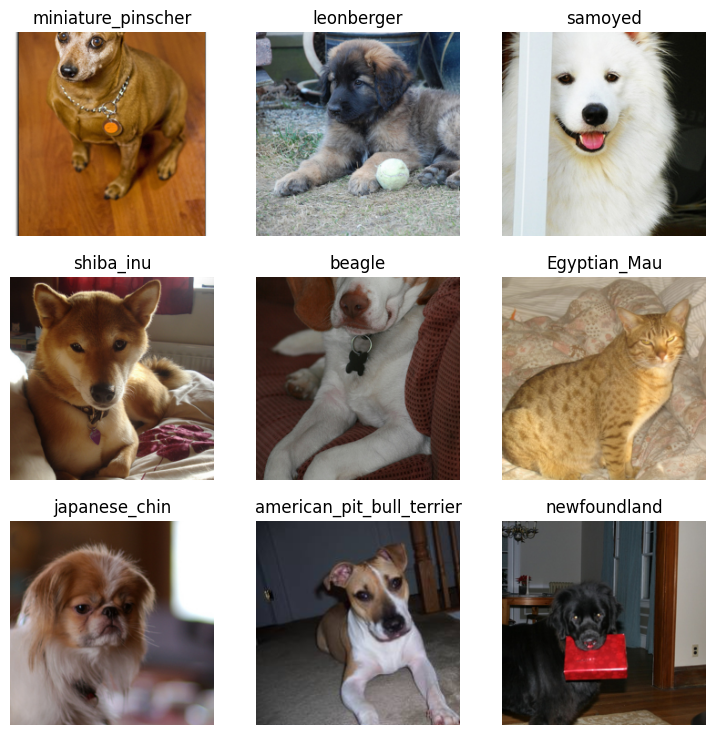

In [18]:
dls.show_batch()

Podemos crear un [Learner](https://docs.fast.ai/learner.html#learner), que es un objeto de fastai que combina los datos y un modelo para el entrenamiento, y utiliza transfer learning para ajustar finamente un modelo preentrenado en solo dos líneas de código:


In [17]:
path_modelo=('/content/drive/MyDrive/Almunos/mascotas_v1.pth')
learn = load_learner(path_modelo)

In [10]:
learn.dls = dls

In [11]:
#learn = vision_learner(dls, resnet34, metrics=error_rate) #Crea un modelo "learner", con ResNet34
learn.fine_tune(1) #Entrenandolo 1 epoca

epoch,train_loss,valid_loss,error_rate,time
0,0.142469,0.023527,0.010149,36:48


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: ignored

La primera línea descargó un modelo llamado ResNet34, preentrenado en [ImageNet](https://www.image-net.org/), y lo adaptó a nuestro problema específico. Luego, ajustó finamente ese modelo y en un tiempo relativamente corto, obtuvimos un modelo con una tasa de error muy por debajo del 1%... ¡increíble!

Si deseas hacer una predicción sobre una nueva imagen, puedes utilizar `learn.predict`:


In [11]:
learn.predict(files[0])

NameError: ignored

El método `predict` devuelve tres cosas: la predicción decodificada (aquí False para perro), el índice de la clase predicha y el tensor de probabilidades de todas las clases en el orden de sus etiquetas indexadas (en este caso, el modelo tiene bastante confianza de que se trata de un perro). Este método acepta un nombre de archivo, una imagen PIL o un tensor directamente en este caso. También podemos echar un vistazo a algunas predicciones con el método [show_results](https://docs.fast.ai/vision.learner.html#show_results):


In [12]:
learn.show_results()

ValueError: ignored

Explora otras aplicaciones como texto o tabulares, así como los otros problemas cubiertos en este tutorial, y verás que todos comparten una API consistente para recopilar y visualizar datos, crear un [Learner](https://docs.fast.ai/learner.html#learner), entrenar el modelo y observar algunas predicciones.


In [16]:
learn.export('/content/drive/MyDrive/Almunos/mascotas.pth')

In [15]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,nan,None,None,00:00


epoch,train_loss,valid_loss,error_rate,time
0,nan,None,None,00:00


## Clasificación de Razas

Para etiquetar nuestros datos con el nombre de la raza, utilizaremos una expresión regular para extraerlo del nombre del archivo. Al observar nuevamente un nombre de archivo:


In [7]:
files[0].name

'scottish_terrier_27.jpg'

La clase es todo antes del último **'_'** seguido de algunos dígitos. Por lo tanto, una expresión regular que capturará el nombre es:


In [8]:
pat = r'^(.*)_\d+.jpg'

Dado que es bastante común utilizar expresiones regulares para etiquetar datos (a menudo, las etiquetas están ocultas en los nombres de archivo), existe un método de fábrica para hacer precisamente eso:


In [19]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

In [20]:
learn.dls = dls


Como antes, podemos utilizar [show_batch](https://docs.fast.ai/vision.gan.html#show_batch) para echar un vistazo a nuestros datos:


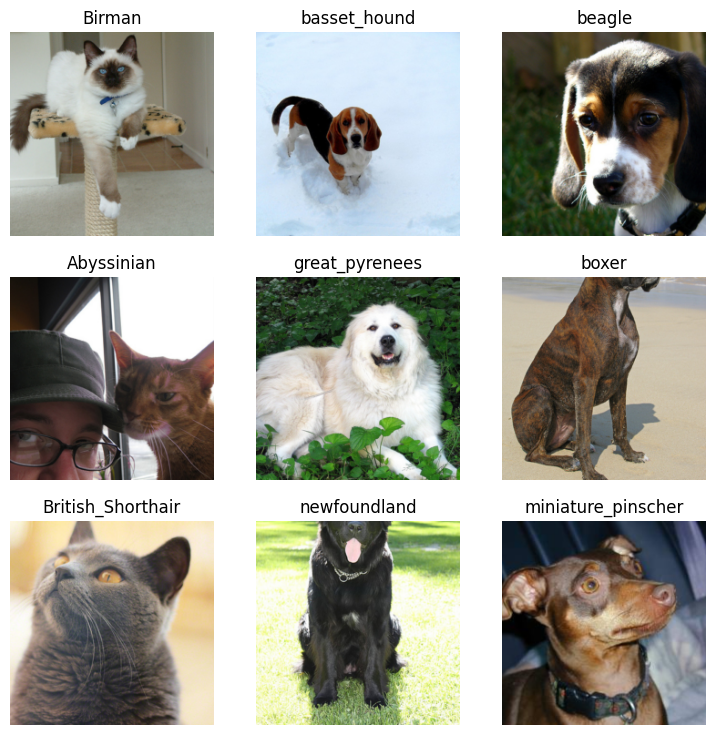

In [21]:
dls.show_batch()

Dado que clasificar la raza exacta de gatos o perros entre 37 razas diferentes es un problema más difícil, cambiaremos ligeramente la definición de nuestros [DataLoaders](https://docs.fast.ai/data.core.html#dataloaders) para usar aumento de datos:


In [22]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

In [23]:
learn.dls = dls

Esta vez redimensionamos a un tamaño más grande antes de agrupar en lotes, y agregamos `batch_tfms`. [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) es una función que proporciona una colección de transformaciones de aumento de datos con valores predeterminados que funcionan bien en muchos conjuntos de datos. Puedes personalizar estas transformaciones al pasar argumentos apropiados a [aug_transforms](https://docs.fast.ai/vision.augment.html#aug_transforms) .


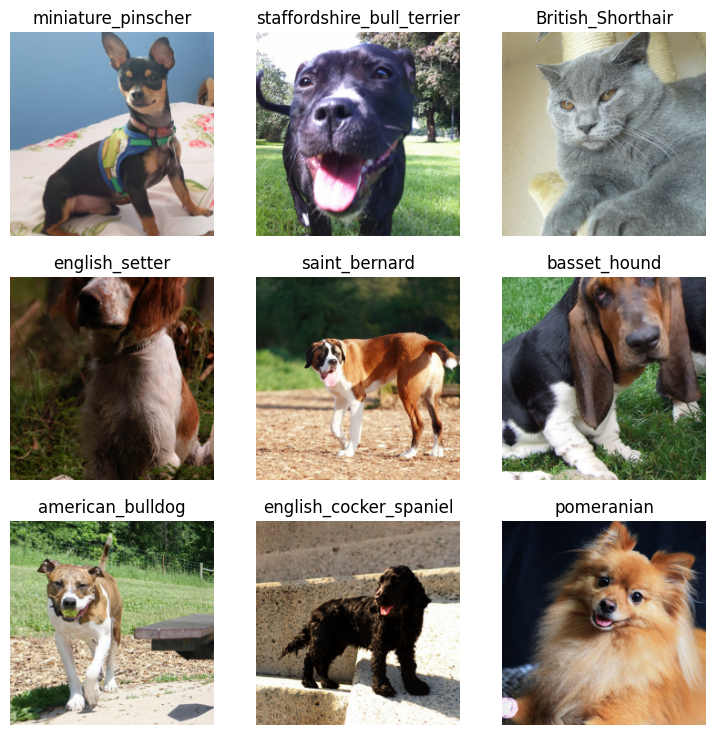

In [24]:
dls.show_batch()

Luego, podemos crear nuestro [Learner](https://docs.fast.ai/learner.html#learner) exactamente como antes y entrenar nuestro modelo.


In [25]:
path_modelo=('/content/drive/MyDrive/Almunos/mascotas_v1.pth')
learn = load_learner(path_modelo)

In [27]:
learn.dls = dls

Antes utilizamos la tasa de aprendizaje predeterminada, pero es posible que queramos encontrar la mejor posible. Para esto, podemos utilizar el Learning Rate Finder:


In [28]:
learn.lr_find()

IndexError: ignored

Genera un gráfico del Learning Rate Finder y nos proporciona dos sugerencias (mínimo dividido por 10 y pendiente más pronunciada). Utilicemos 3e-3 en este caso. También aumentaremos el número de épocas:


In [29]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,error_rate,time


IndexError: ignored

>>fine_tune(2, 3e-3): Este método realiza un ajuste fino adicional al modelo. La primera entrada 2 indica el número de épocas de entrenamiento adicionales que se realizarán. La segunda entrada 3e-3 especifica la tasa de aprendizaje utilizada durante este ajuste fino. Una tasa de aprendizaje más baja suele ser apropiada en la etapa de ajuste fino para evitar cambios demasiado bruscos en los pesos del modelo.
Este ajuste fino es útil cuando ya has entrenado el modelo inicialmente (fine_tune(1)) y deseas refinarlo aún más con un conjunto de datos específico.

Recuerda ajustar los valores de acuerdo a tus necesidades específicas y experimentar con diferentes configuraciones para obtener el mejor rendimiento del modelo.

Una vez más, podemos echar un vistazo a algunas predicciones con `show_results`:


In [28]:
learn.show_results()

KeyboardInterrupt: ignored

Otra cosa útil es un objeto de interpretación, que puede mostrarnos dónde el modelo hizo las peores predicciones:


In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))


## Clasificación de Una Sola Etiqueta - Con el Uso de la API de Bloques de Datos

También podemos utilizar la API de bloques de datos para obtener nuestros datos en un objeto `DataLoaders`. Esto es un poco más avanzado, así que si no te sientes cómodo aprendiendo nuevas API, siéntete libre de omitir esta parte por ahora.

Un bloque de datos se construye proporcionando a la biblioteca fastai una serie de información:


La construcción de un bloque de datos con la API de bloques de datos implica proporcionar a la biblioteca fastai varios tipos de información a través de un argumento llamado `blocks`:

- Los tipos utilizados, a través de un argumento llamado `blocks`. En este caso, tenemos imágenes y categorías, por lo que pasamos `ImageBlock` y `CategoryBlock`.
- Cómo obtener los elementos sin procesar, en este caso, nuestra función `get_image_files`.
- Cómo etiquetar esos elementos, en este caso, con la misma expresión regular que antes.
- Cómo dividir esos elementos, en este caso, con un divisor aleatorio.
- Las transformaciones `item_tfms` y `batch_tfms` como antes.


In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

El objeto `pets` en sí mismo está vacío: solo contiene las funciones que nos ayudarán a recopilar los datos. Tenemos que llamar al método `dataloaders` para obtener un objeto `DataLoaders`. Le pasamos la fuente de los datos:


In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")

Luego, podemos ver algunas de nuestras imágenes con `dls.show_batch()`:


In [ ]:
dls.show_batch(max_n=9)

## Clasificación Multi-etiqueta

Para esta tarea, utilizaremos el conjunto de datos Pascal, que contiene imágenes con diferentes tipos de objetos/personas. Originalmente es un conjunto de datos para la detección de objetos, lo que significa que la tarea no es solo detectar si hay una instancia de una clase en una imagen, sino también dibujar un cuadro delimitador alrededor de ella. Aquí intentaremos predecir todas las clases en una imagen dada.

La clasificación multi-etiqueta difiere de la clasificación de una sola etiqueta en el sentido de que cada imagen no pertenece a una sola categoría. Una imagen podría tener una persona y un caballo en su interior, por ejemplo, o no tener ninguna de las categorías que estudiamos.

Como antes, podemos descargar el conjunto de datos bastante fácilmente:


In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

La información sobre las etiquetas de cada imagen se encuentra en el archivo llamado `train.csv`. Lo cargamos usando pandas:


In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

## Clasificación Multi-etiqueta - Uso de la API de Alto Nivel

Eso es bastante sencillo: para cada nombre de archivo, obtenemos las diferentes etiquetas (separadas por espacio) y la última columna indica si está en el conjunto de validación o no. Para obtener esto rápidamente en un objeto `DataLoaders`, tenemos un método de fábrica, `from_df`. Podemos especificar la ruta subyacente donde se encuentran todas las imágenes, una carpeta adicional para agregar entre la ruta base y los nombres de archivo (aquí, `train`), la columna `valid_col` para considerar en el conjunto de validación (si no especificamos esto, tomamos un subconjunto aleatorio), un `label_delim` para dividir las etiquetas y, como antes, `item_tfms` y `batch_tfms`.

Ten en cuenta que no tenemos que especificar `fn_col` y `label_col` porque por defecto son la primera y segunda columna, respectivamente.


In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

Como antes, podemos echar un vistazo a los datos con el método show_batch.

In [ ]:
dls.show_batch()

Entrenar un modelo es tan fácil como antes: las mismas funciones se pueden aplicar y la biblioteca fastai detectará automáticamente que estamos en un problema de clasificación multi-etiqueta, eligiendo así la función de pérdida adecuada. La única diferencia está en la métrica que pasamos: `error_rate` no funcionará para un problema de clasificación multi-etiqueta, pero podemos usar `accuracy_thresh` y `F1ScoreMulti`. También podemos cambiar el nombre predeterminado de una métrica; por ejemplo, podríamos querer ver los puntajes F1 con un promedio de macro y de muestras.


In [ ]:
1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

Como antes, podemos usar learn.lr_find para elegir una buena tasa de aprendizaje:

In [ ]:
learn.lr_find()

Podemos elegir la tasa de aprendizaje sugerida y ajustar nuestro modelo previamente entrenado:

In [ ]:
learn.fine_tune(2, 3e-2)

Como antes, podemos echar un vistazo fácilmente a los resultados:

In [ ]:
learn.show_results()

Or get the predictions on a given image:

In [ ]:
learn.predict(path/'train/000005.jpg')

Al igual que con las predicciones de clasificación única, obtenemos tres cosas. La última corresponde a la predicción del modelo en cada clase (que va de 0 a 1). La penúltima corresponde a las etiquetas codificadas en one-hot (obtenemos Verdadero para todas las clases predichas, las que tienen una probabilidad > 0.5), y la primera es la versión decodificada y legible.

Y como antes, podemos verificar dónde el modelo tuvo peores resultados:


In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

## Clasificación Multi-etiqueta - Uso de la API de Bloques de Datos

También podemos utilizar la API de bloques de datos para obtener nuestros datos en un objeto `DataLoaders`. Como dijimos antes, si no te sientes cómodo aprendiendo nuevas API, siéntete libre de omitir esta parte por ahora.

Recuerda cómo está estructurada la información en nuestro marco de datos:


In [ ]:
df.head()

En este caso, construimos el bloque de datos proporcionando:

- Los tipos utilizados: `ImageBlock` y `MultiCategoryBlock`.
- Cómo obtener los elementos de entrada desde nuestro marco de datos: aquí leemos la columna `fname` y necesitamos agregar `path/train/` al principio para obtener nombres de archivo adecuados.
- Cómo obtener los objetivos de nuestro marco de datos: aquí leemos la columna `labels` y necesitamos dividir por espacio.
- Cómo dividir los elementos, aquí usando la columna `is_valid`.
- Las transformaciones `item_tfms` y `batch_tfms` como antes.


In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))

Este bloque es ligeramente diferente al anterior: no necesitamos pasar una función para recopilar todos nuestros elementos, ya que el marco de datos que daremos ya los tiene todos. Sin embargo, sí necesitamos procesar la fila de ese marco de datos para obtener nuestras entradas, razón por la cual pasamos un `get_x`. Por defecto, es la función de fastai `noop`, razón por la cual no necesitamos pasarla antes.

Como antes, `pascal` es solo un modelo. Necesitamos pasarle la fuente de nuestros datos para poder obtener `DataLoaders`:


In [ ]:
dls = pascal.dataloaders(df)

Luego podemos ver algunas de nuestras imágenes con dls.show_batch()

In [ ]:
dls.show_batch(max_n=9)